<h3> Overall Takeaways </h3>

Many different approaches to stock prediction, using a variety of types of datasets. Unfortunately, some of the approaches utilize concepts that will be covered later in the course, so for these approaches, I will summarize my learnings for the future, when I'm able to implement these approaches.

<ol>
  <li> Stock prediction using traditional ML approaches and quantitative data - Stefan Jansen </li>
    Many different approaches outlined in his textbook, however, I will start with RNN on S&P 500 data to predict the price. <br />
  https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/19_recurrent_neural_nets/01_univariate_time_series_regression.ipynb
  <li> Stock prediction using financial news and technical + fundamental data - Astock dataset </li>
  While I do not feel like I have the tools to pursue this approach at the moment, I believe that my final project should include at least one NLP approach, and this is one such example. I will summarize (to the best of my abilities) the approach and the results in this PapersWithCode project on using financial news.
  <li> Twitter based NLP? </li>
  https://github.com/yumoxu/stocknet-dataset
</ol>


In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

<h3> Approach One: RNN </h3>

Following the approach laid out by stefan jansen, we use RNN to predict time series data of the S&P 500.

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

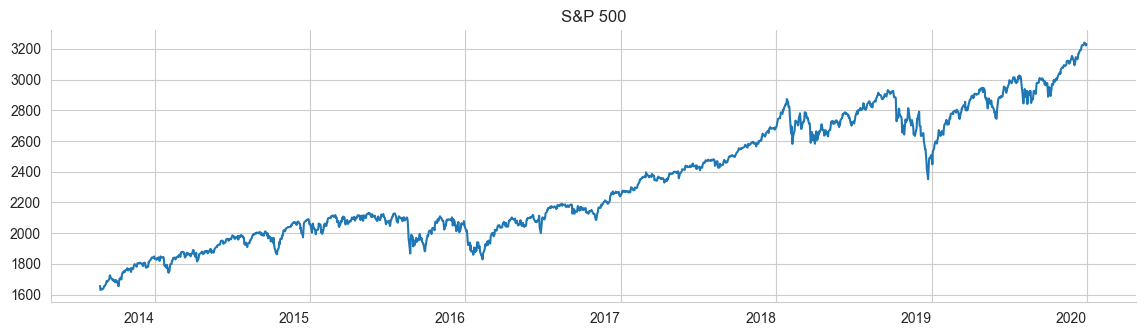

In [5]:
### Import Data from Federal Reserve Bank’s Data Service FRED ###

sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [18]:
### Function to create univariate time series data for training an RNN model ###

def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    print(X)
    return pd.DataFrame(X, index=y.index), y

sp500.shape

(1599, 1)

In [19]:
### Normalize Data ###
scaler = MinMaxScaler()
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)

window_size = 63

### Create Data ###
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)



[[0.01634007 0.         0.0027834  ... 0.0977857  0.09374728 0.10274364]
 [0.         0.0027834  0.00477776 ... 0.09374728 0.10274364 0.10827938]
 [0.0027834  0.00477776 0.00154703 ... 0.10274364 0.10827938 0.10686283]
 ...
 [0.82713695 0.83642531 0.81375424 ... 0.99005306 0.98966164 0.99993166]
 [0.83642531 0.81375424 0.78104924 ... 0.98966164 0.99993166 1.        ]
 [0.81375424 0.78104924 0.79535147 ... 0.99993166 1.         0.98836313]]


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2013-11-22,0.016340,0.000000,0.002783,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,...,0.087062,0.087857,0.085248,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744
2013-11-25,0.000000,0.002783,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,...,0.087857,0.085248,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279
2013-11-26,0.002783,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,0.036439,...,0.085248,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279,0.106863
2013-11-27,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,0.036439,0.032891,...,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279,0.106863,0.107031
2013-11-29,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,0.036439,0.032891,0.035731,...,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279,0.106863,0.107031,0.109814


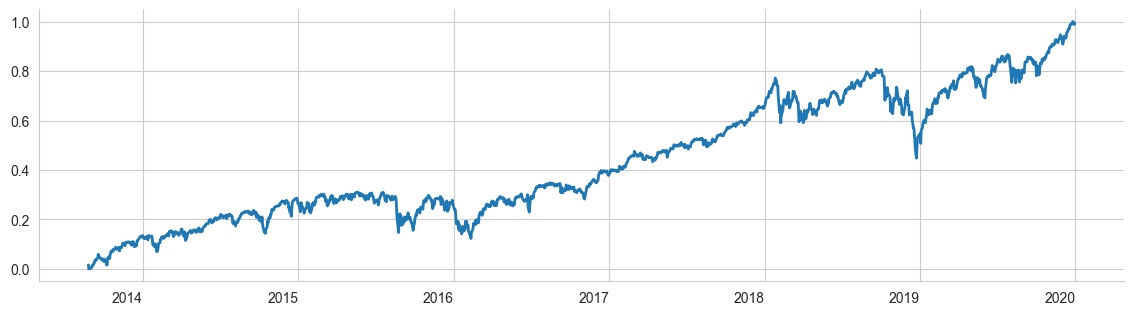

In [14]:
### View Data ###

ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [16]:
### Train-test split ###

X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

### Train on data up to 2018 ###
X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

### Test on data from 2019 ###
X_test = X['2019':].values.reshape(-1, window_size, 1)
y_test = y['2019':]

n_obs, window_size, n_features = X_train.shape

y_train.shape

X

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2013-11-22,0.016340,0.000000,0.002783,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,...,0.087062,0.087857,0.085248,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744
2013-11-25,0.000000,0.002783,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,...,0.087857,0.085248,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279
2013-11-26,0.002783,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,0.036439,...,0.085248,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279,0.106863
2013-11-27,0.004778,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,0.036439,0.032891,...,0.094139,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279,0.106863,0.107031
2013-11-29,0.001547,0.005772,0.014041,0.015284,0.015340,0.025616,0.033246,0.036439,0.032891,0.035731,...,0.099494,0.104191,0.100060,0.097786,0.093747,0.102744,0.108279,0.106863,0.107031,0.109814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.841476,0.836972,0.827137,0.836425,0.813754,0.781049,0.795351,0.821061,0.812847,0.784435,...,0.933211,0.938871,0.955608,0.955751,0.969824,0.970488,0.969631,0.978472,0.988320,0.990053
2019-12-26,0.836972,0.827137,0.836425,0.813754,0.781049,0.795351,0.821061,0.812847,0.784435,0.800800,...,0.938871,0.955608,0.955751,0.969824,0.970488,0.969631,0.978472,0.988320,0.990053,0.989662
2019-12-27,0.827137,0.836425,0.813754,0.781049,0.795351,0.821061,0.812847,0.784435,0.800800,0.812437,...,0.955608,0.955751,0.969824,0.970488,0.969631,0.978472,0.988320,0.990053,0.989662,0.999932


In [30]:
### Create RNN Model ###

rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
### Define optimizer for RNN ###

optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

### Compile RNN w/ previously defined optimizer ###
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

### Save best path of model during training ###
rnn_path = (results_path / 'rnn.h5').as_posix()

### Call best model during training ###
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

### Early stopping to prevent overfitting ###
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

### Train model ###
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=2)

Epoch 1/150

Epoch 1: val_loss improved from inf to 0.00027, saving model to results/univariate_time_series\rnn.h5
66/66 - 3s - loss: 2.3548e-04 - val_loss: 2.6582e-04 - 3s/epoch - 39ms/step
Epoch 2/150

Epoch 2: val_loss improved from 0.00027 to 0.00026, saving model to results/univariate_time_series\rnn.h5
66/66 - 1s - loss: 2.2989e-04 - val_loss: 2.5554e-04 - 734ms/epoch - 11ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 0.00026
66/66 - 1s - loss: 2.2925e-04 - val_loss: 0.0012 - 724ms/epoch - 11ms/step
Epoch 4/150

Epoch 4: val_loss did not improve from 0.00026
66/66 - 1s - loss: 2.2650e-04 - val_loss: 4.2049e-04 - 706ms/epoch - 11ms/step
Epoch 5/150

Epoch 5: val_loss did not improve from 0.00026
66/66 - 1s - loss: 2.1100e-04 - val_loss: 3.2568e-04 - 710ms/epoch - 11ms/step
Epoch 6/150

Epoch 6: val_loss improved from 0.00026 to 0.00024, saving model to results/univariate_time_series\rnn.h5
66/66 - 1s - loss: 2.1445e-04 - val_loss: 2.3603e-04 - 725ms/epoch - 11ms/step


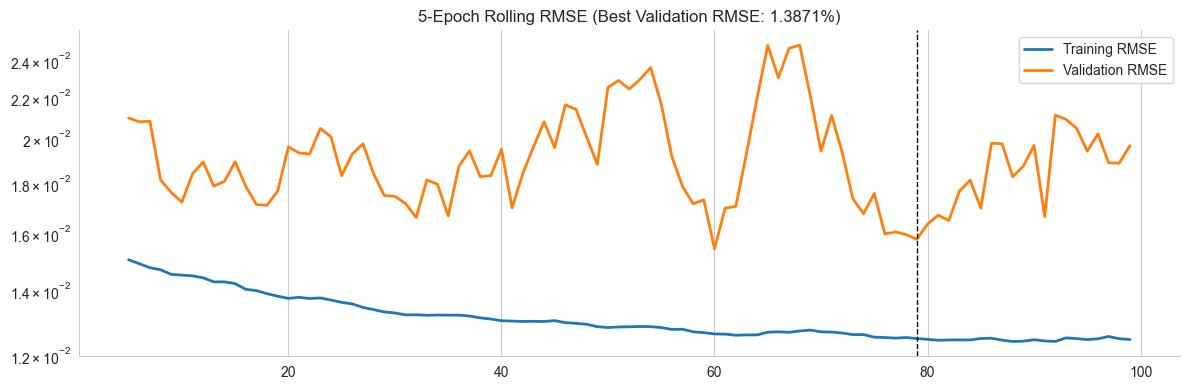

In [33]:
### Plot performance ###

fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300)

In [17]:
### More performance benchmarks ###

train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0129 | Test RMSE: 0.0142


In [34]:
### We trained on scaled data, therefore our predictions are in scaled form ###
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

### Correlation coefficient between predicted and actual values ###
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

8/8 [==============================] - 0s 3ms/step
Train IC: 0.9960 | Test IC: 0.9817


<h3> Major Takeaways </h3>

This approach can be more broadly applied to a variety of quantitative data sources, using a variety of different model types. Fundamentally, this approach breaks down to utilizing a single stock, training on past data, and testing on the same stock data (of a more recent timeframe)
<br />
<br />
After speaking with my mentor, RNN appears to have fairly good performance, therefore we chose to pursue RNN as our first example. In future stages of the project, I will generalize/expand this approach to include different models and different data sources.


<h3> Approach 2: NLP </h3>
Although not directly a stock prediction, we explore how we can use NLP to do sentiment analysis on tweets. We do so following the methodology laid out by stefan jansen.

Notebook link: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/14_working_with_text_data/05_sentiment_analysis_twitter.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [4]:
### Data import ###

from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile

path = Path('sentiment140')
if not path.exists():
    path.mkdir()

URL = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

response = requests.get(URL).content

with ZipFile(BytesIO(response)) as zip_file:
    for i, file in enumerate(zip_file.namelist()):
        if file.startswith('train'):
            local_file = path / 'train.csv'
        elif file.startswith('test'):
            local_file = path / 'test.csv'
        else:
            continue
        with local_file.open('wb') as output:
            for line in zip_file.open(file).readlines():
                output.write(line)

In [15]:
data_path = Path('twitter-data', 'sentiment140')
if not data_path.exists():
    data_path.mkdir(parents=True)

data_path

WindowsPath('data/sentiment140')

In [16]:
names = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [19]:
### Preprocessing data ###

def load_train_data():
    parquet_file = data_path / 'train.parquet'
    if not parquet_file.exists():
        df = (pd.read_csv(data_path / 'train.csv',
                          low_memory=False,
                          encoding='latin1',
                          header=None,
                          names=names,
                          parse_dates=['date'])
              .drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[df.text.str.len() <= 140]
        df.polarity = (df.polarity > 0).astype(int)
        df.to_parquet(parquet_file)
        return df
    else:
        return pd.read_parquet(parquet_file)
    
train = load_train_data()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1566668 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   polarity  1566668 non-null  int32         
 1   date      1566668 non-null  datetime64[ns]
 2   user      1566668 non-null  object        
 3   text      1566668 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 53.8+ MB


In [20]:
def load_test_data():
    parquet_file = data_path / 'test.parquet'
    if not parquet_file.exists():
        df = (pd.read_csv('data/sentiment140/test.csv',
                          low_memory=False,
                          encoding='latin1',
                          header=None,
                          names=names,
                          parse_dates=['date'])
              .drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[(df.text.str.len() <= 140) &
                (df.polarity.isin([0, 4]))]
        df.to_parquet(parquet_file)
        return df
    else:
        return pd.read_parquet(parquet_file)
    
test = load_test_data()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 0 to 497
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  354 non-null    int64 
 1   date      354 non-null    object
 2   user      354 non-null    object
 3   text      354 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.8+ KB


In [21]:
train.head()

,polarity,date,user,text
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


In [22]:
### Polarity ###

train.polarity = (train.polarity>0).astype(int)
train.polarity.value_counts()

polarity
1    784335
0    782333
Name: count, dtype: int64

In [23]:
test.polarity = (test.polarity>0).astype(int)
test.polarity.value_counts()

polarity
1    180
0    174
Name: count, dtype: int64

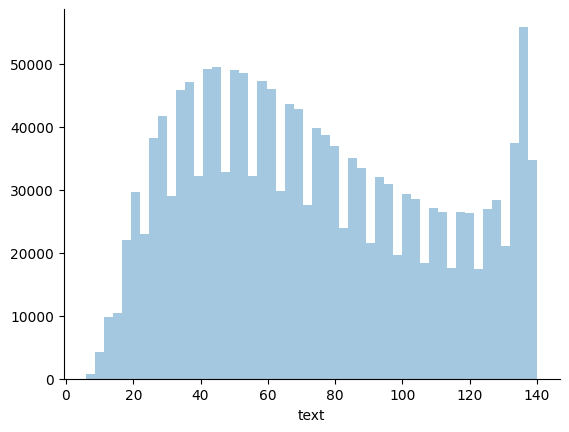

In [25]:
sns.distplot(train.text.str.len(), kde=False)
sns.despine()

In [26]:
### Text vectorizer ###

vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)

test_dtm = vectorizer.transform(test.text)

train_dtm

<1566668x934 sparse matrix of type '<class 'numpy.int64'>'
	with 6332930 stored elements in Compressed Sparse Row format>

In [27]:
### Naive bayes ###

nb = MultinomialNB()
nb.fit(train_dtm, train.polarity)

predicted_polarity = nb.predict(test_dtm)

accuracy_score(test.polarity, predicted_polarity)

0.7768361581920904

In [29]:
### Using textblob for sentiment analysis and a positive sentiment example ###

sample_positive = train.text.loc[256332]
print(sample_positive)
parsed_positive = TextBlob(sample_positive)
parsed_positive.polarity

Ok its cake and ice cream time! Ha! See what I'm talking about! The temptation is there! 


1.0

In [30]:
### Negative example ###

sample_negative = train.text.loc[636079]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

 i hate this place


-0.8

In [31]:
### apply sentiment analysis to data ###

def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

train[['text']].sample(10).assign(sentiment=lambda x: x.text.apply(estimate_polarity)).sort_values('sentiment')

,text,sentiment
188940,Fuck. Worst dream ever. Dream hangover.,-0.700000
130538,i'm sorry mom PLEASE PRAY FOR ME,-0.500000
744850,i dont want to study but w/e,0.000000
706960,"@ormsweird -- Eeek! Get some rest, that's pro...",0.000000
145521,"@Hawkbow Yeah, especially since I asked and di...",0.068182
142605,@marcnobbs Send some over here Pleeeeeese. Hav...,0.166667
262370,Dang my whole body is sore from swimming I nee...,0.200000
626087,Blackberry Tour comes out for Telus on July 15...,0.225000
1586606,is so pleased Bodie took the doggies out for t...,0.500000
1218741,@JLSOfficial hey marvin when u do u tour will...,0.500000


In [32]:
test['sentiment'] = test.text.apply(estimate_polarity)

accuracy_score(test.polarity, (test.sentiment>0).astype(int))

0.7429378531073446

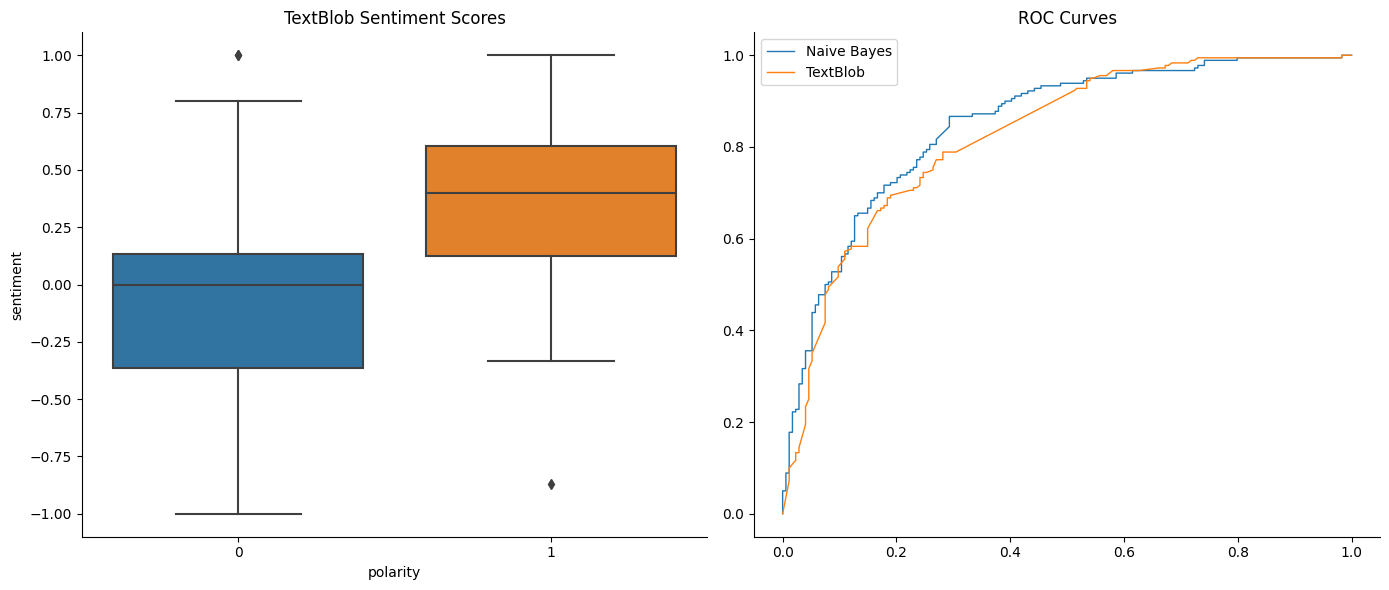

In [34]:
### Plots showing that naive bayes out performs TextBlob ###

fpr_tb, tpr_tb, _ = roc_curve(y_true=test.polarity, y_score=test.sentiment)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
sns.despine()
fig.tight_layout();

<h3> Major Takeaways </h3>

Sentiment analysis is a fascinating area that could supplement quantitative data directly from the market. It would be interesting to compare the performance of models with only quantitative data, vs quantitative + sentiment analysis, vs only sentimental analysis. It would also be very interesting to analyze different text sources (twitter vs yahoo news vs seeking alpha, for example) and see how different models trained on these sources would have varying performance.


<h3> Approach 3: Twitter based NLP </h3>

An example of combining the first two approaches, combining twitter data for NLP and stock data for the final model. Utilizes deep generative modeling, which was a bit difficult to understand when reading through the paper. Did not appear to have the code publicly available (however, the dataset is publicly available). Can be used as inspiration for one approach for the final project!

Paper: https://aclanthology.org/P18-1183.pdf
Dataset: https://github.com/yumoxu/stocknet-dataset